![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Evangelia Balini |
<b>Student-nr</b>: r0830140 |
<b>Date</b>: June 02, 2021
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition is mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. The face match process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors that can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * 1. Read caltech dataset
    * 2. Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * 1. Detect faces
    * 2. Print statistics of data
    * 3. Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * 1. Eigenfaces for face recognition
    * 2. Fisherfaces for face recognition
    * 3. LBP for face recognition
    * 4. Deep metric learning
        * 4.1 Deep Metric Learning using Siamese Networks
        
* [IV. Classification in typical biometrics setting](#IV.-Classification-in-typical-biometrics-setting)
* [V. Advanced classification scenario](#V.-Advanced-classification-scenario)
* [VI. Evaluation](#VI.-Evaluation)
    * 1. Validation as verification system
    * 2. Validation as identification system
    * 3. Validation in multi-classification setting
    
* [VII. Task](#VII.-Task)
    * 1. Mandatory tasks
    * 2. Tasks of choice

**Note: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [29]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy.stats import gaussian_kde
import shapely
from shapely.geometry import Point, LineString
from itertools import product

import pickle

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [30]:
# size of each face after preprocessing
face_size=(47, 47)

In [31]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

### 2. Inspect some images

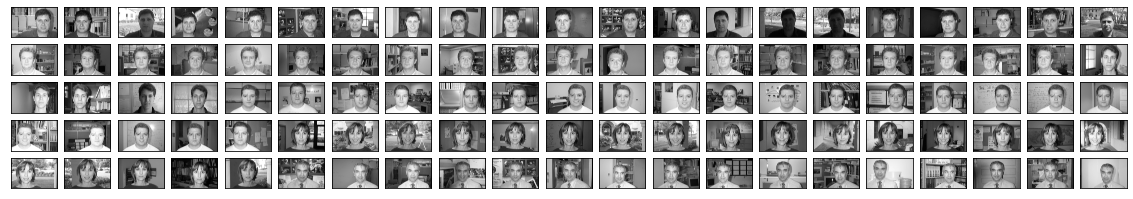

In [32]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. Please study the relevant publications on these detectors to understand their functioning.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html).

In [33]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [34]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
#     if len(faces)==0:
#         print('Fail', str(label))

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)
        
# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [35]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

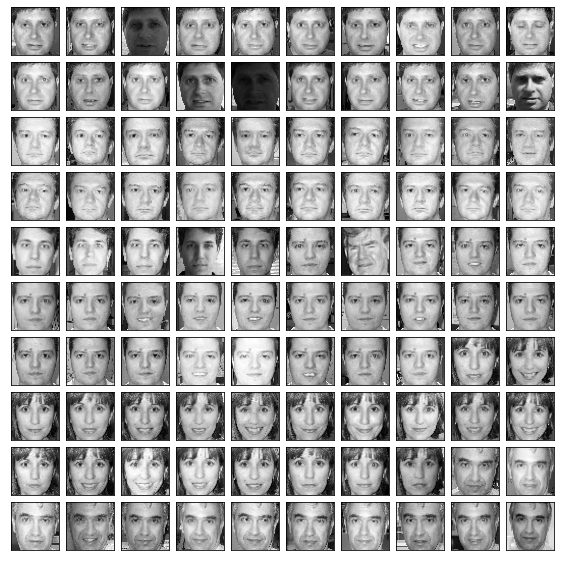

In [36]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [37]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.PCA
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. ([Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images (presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [38]:
#Imports necessary for the descriptors
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

In [39]:
DESC=FeatureDescriptor.PCA

In [40]:
if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    
    dist_metric_pca = euclidean

num_components 35


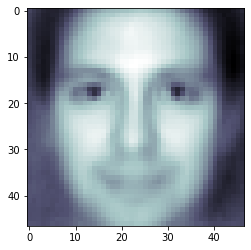

In [41]:
#Show mean face of caltech 
plt.imshow(desc.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

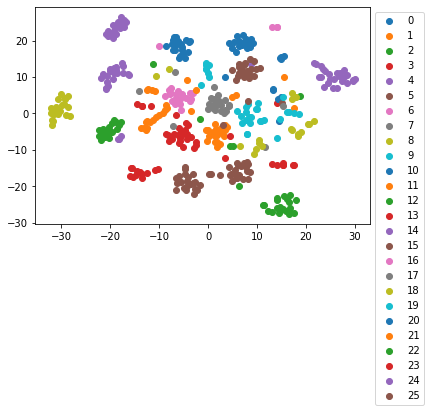

In [42]:
from sklearn.manifold import TSNE

def plot_tsne(emb):
    X_embedded = TSNE(n_components=2).fit_transform(emb)

    for i, t in enumerate(set(targets)):
        idx = targets == t
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));
    
plot_tsne(X_pca)

### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is [Linear Discriminant Analysis (LDA)](http://www.scholarpedia.org/article/Linear_Discriminant_Analysis), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [43]:
DESC = FeatureDescriptor.LDA

In [44]:
if DESC == FeatureDescriptor.LDA:
    #num_components = min(num_components, min(n_samples, n_features))
    num_components = 25
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    
    dist_metric_lda = euclidean

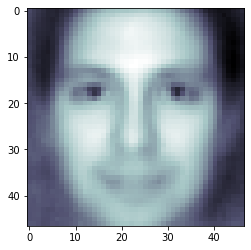

In [45]:
lda_mean =  desc.means_
plt.imshow(np.mean(lda_mean, axis=0).reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

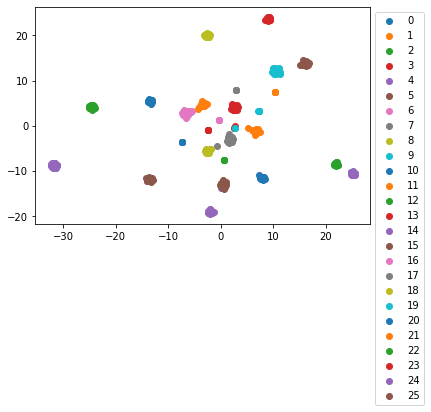

In [46]:
plot_tsne(X_lda)

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [47]:
DESC = FeatureDescriptor.LBP

In [48]:
def CHI2(histA, histB, eps=1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
        # return the chi-squared distance
        return d

In [49]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp = desc.describe_list(faces.images[...,0])
    
    #dist_metric_lbp = chisquare
    dist_metric_lbp = CHI2

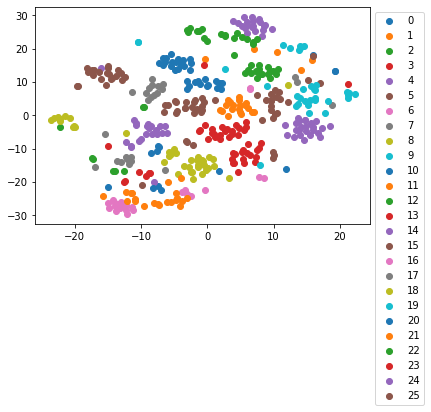

In [50]:
plot_tsne(embedded_lbp)

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 


2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



#### 4.1 Deep Metric Learning using Siamese Networks

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [51]:
DESC = FeatureDescriptor.DL

In [52]:
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

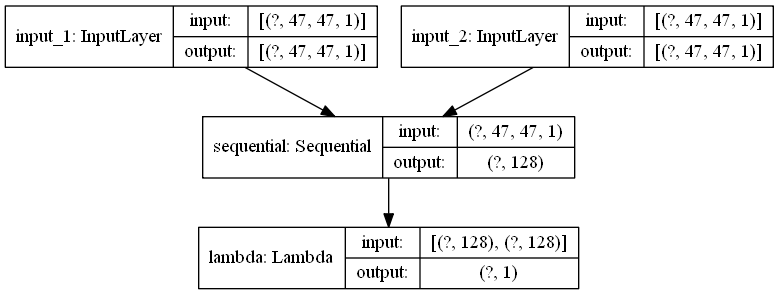

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [54]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

In [55]:
if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_dl = encoder(faces.images.astype(float)).numpy()

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 - 4s - loss: 0.1003 - accuracy: 0.7146 - val_loss: 0.0557 - val_accuracy: 0.8844
Epoch 2/10
1200/1200 - 1s - loss: 0.0385 - accuracy: 0.9301 - val_loss: 0.0316 - val_accuracy: 0.9656
Epoch 3/10
1200/1200 - 1s - loss: 0.0207 - accuracy: 0.9778 - val_loss: 0.0231 - val_accuracy: 0.9844
Epoch 4/10
1200/1200 - 1s - loss: 0.0140 - accuracy: 0.9942 - val_loss: 0.0199 - val_accuracy: 0.9875
Epoch 5/10
1200/1200 - 1s - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.0199 - val_accuracy: 0.9750
Epoch 6/10
1200/1200 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9844
Epoch 7/10
1200/1200 - 1s - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.0161 - val_accuracy: 0.9844
Epoch 8/10
1200/1200 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9812
Epoch 9/10
1200/1200 - 1s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 0.9812
Epoch 10/10
1200/1200 - 1s - loss: 

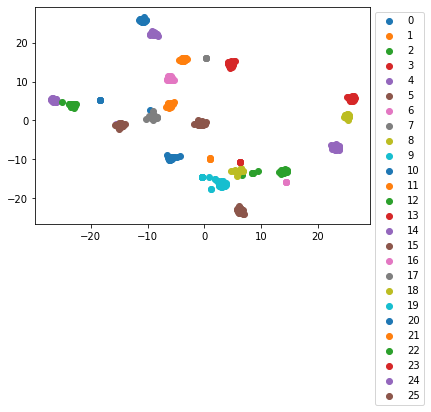

In [56]:
plot_tsne(embedded_dl)

## IV. Classification in typical biometrics setting

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute pair-wise matching scores
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. 

In [57]:
from numpy import linalg

#Method insipred by "Construct similarity tensror" from Assignment 2.

def construct_sim_matrix(embeddings, targets, dist_func, exclude_img_duplicates=True):
    data = []
    n_images = len(targets)
    for i,j in product(range(n_images), range(n_images)):
        # if comparing the same image
        if exclude_img_duplicates and i == j:
            continue
        if dist_func==euclidean:
            dist = dist_func(embeddings[i], embeddings[j])
            sim = 1/(1+dist)
        elif dist_func==chisquare:
            #dist = cv2.compareHist(np.float32(embeddings[i]), np.float32(embeddings[j]), cv2.HISTCMP_CHISQR)
            dist = CHI2(embeddings[i], embeddings[j])
            sim = 1/(1+dist)
        else:
            dist = get_norm(embeddings[i], embeddings[j])
            sim = 1/(1+dist)
        
        data.append([targets[i], targets[j],sim])
        
    df = pd.DataFrame(data, columns=['p1', 'p2', 'd'])
    sim_mat = df.pivot_table(index='p1', columns='p2',values='d',aggfunc = np.mean)
    return sim_mat


def get_norm(e1, e2):
    '''Norm 2 as a distance metric for Siamese networks'''
    d = linalg.norm(e1 - e2, ord=2)
    return d

In [58]:
#Construct similarity matrices
sim_mat_pca = construct_sim_matrix(embedded_pca, targets, dist_metric_pca)

In [59]:
sim_mat_lda = construct_sim_matrix(embedded_lda, targets, dist_metric_lda)

In [60]:
sim_mat_lbp = construct_sim_matrix(embedded_lbp, targets, dist_metric_lbp)

In [61]:
sim_mat_dl = construct_sim_matrix(embedded_lbp, targets, dist_func=get_norm)

In [62]:
#Save matrices here
pickle.dump(sim_mat_pca, open( "sim_mat_pca.p", "wb" ))
pickle.dump(sim_mat_lda, open( "sim_mat_lda.p", "wb" ))
pickle.dump(sim_mat_lbp, open( "sim_mat_lbp.p", "wb" ))
pickle.dump(sim_mat_dl, open( "sim_mat_dl.p", "wb" ))

In [63]:
sim_mat_pca = pickle.load( open( "sim_mat_pca.p", "rb" ) )
sim_mat_lda = pickle.load( open( "sim_mat_lda.p", "rb" ) )
sim_mat_lbp = pickle.load( open( "sim_mat_lbp.p", "rb" ) )
sim_mat_dl = pickle.load( open( "sim_mat_dl.p", "rb" ) )

## V. Advanced classification scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

Here you find an example with KNN as classifiers and their validation results. 

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Holdout on dataset
X_train_class_pca, X_test_class_pca, y_train_class_pca, y_test_class_pca = holdout_split(embedded_pca, faces.target)
X_train_class_lbp, X_test_class_lbp, y_train_class_lbp, y_test_class_lbp = holdout_split(embedded_lbp, faces.target)
X_train_class_lda, X_test_class_lda, y_train_class_lda, y_test_class_lda = holdout_split(embedded_lda, faces.target)
X_train_class_dl, X_test_class_dl, y_train_class_dl, y_test_class_dl = holdout_split(embedded_dl, faces.target)

### KNN classifier

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_class_pca, y_train_class_pca)

acc_knn_pca = accuracy_score(y_test_class_pca, knn.predict(X_test_class_pca))
print(f'KNN accuracy - PCA = {acc_knn_pca}')

KNN accuracy - PCA = 0.9090909090909091


## VI. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

In [66]:
#Function that was taken from the BSSR1 file from Assignent 1, at its entirety

def sim2scores(similarity_matrix):
    # use .values to access as numpy array
    np_similarity_matrix = similarity_matrix.values

    # grab elements on the diagonal
    genuine_scores = np.diag(np_similarity_matrix)

    # mask elements that are on the diagonal, retain non-diagonal elements
    imposter_scores =  np_similarity_matrix[~np.eye(np_similarity_matrix.shape[0],dtype=bool)]

    # store in one single list of scores as required for the classification validation procedures
    scores = np.append(np.array(genuine_scores), np.array(imposter_scores))

    # normalize to [0,1] range, 0 corresponding to minimal similarity
    scores = (scores - scores.min())/(scores.max()-scores.min())

    ## add the genuine and imposter labels

    # tag genuine combinations as label 1 and imposter combinations as 0

    genuine_id = np.zeros_like(scores)
    genuine_id[0:genuine_scores.shape[0]] = 1

    return(genuine_id, scores)

genuine_id_pca, scores_pca = sim2scores(sim_mat_pca)
genuine_id_dl, scores_dl = sim2scores(sim_mat_dl)
genuine_id_lda, scores_lda = sim2scores(sim_mat_lda)
genuine_id_lbp, scores_lbp = sim2scores(sim_mat_lbp)

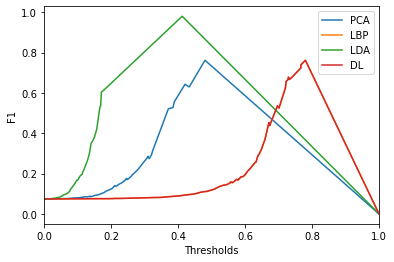

In [67]:
def getF1(mask, scores):
    '''Gets the F1 value for all the thresholds'''
    _, _, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    f_values = []
    for t in thresholds:
        f_values.append(f1_score(mask,[1 if m > t else 0 for m in scores], average='binary', pos_label=1))

    f_values_np = np.array(f_values)
    return f_values_np

def plot_F1(mask, scores, name):
    '''Plots F1 against the thresholds'''
    _, _, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    f_values = []
    for t in thresholds:
        f_values.append(f1_score(mask,[1 if m > t else 0 for m in scores], average='binary', pos_label=1))
    
    plt.plot(thresholds, f_values, label = name)
    plt.legend()
    plt.xlabel('Thresholds')
    plt.xlim((0, 1))
    plt.ylabel('F1')

def getAccuracies(mask, scores):  
    '''Gets accuracies for all the thresholds'''
    _, _, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    accuracies = []
    for t in thresholds:
        accuracies.append(accuracy_score(mask,[1 if m > t else 0 for m in scores]))

    accuracies_np = np.array(accuracies)
    return accuracies_np

def plot_Accuracy(mask, scores, name):
    '''Plots accuracy against the thresholds'''
    _, _, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    accuracies = []
    for t in thresholds:
        accuracies.append(accuracy_score(mask,[1 if m > t else 0 for m in scores]))

    plt.plot(thresholds, accuracies, label = name)
    plt.legend()
    plt.xlabel('Threshold')
    plt.xlim((0,1)) #Limiting the showing x axis
    plt.ylabel('Accuracy') 


plot_F1(genuine_id_pca, scores_pca, 'PCA')
plot_F1(genuine_id_lbp, scores_lbp, 'LBP')
plot_F1(genuine_id_lda, scores_lda, 'LDA')
plot_F1(genuine_id_dl, scores_dl, 'DL')

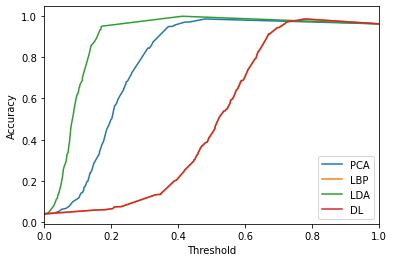

In [68]:
plot_Accuracy(genuine_id_pca, scores_pca, 'PCA')
plot_Accuracy(genuine_id_lbp, scores_lbp, 'LBP')
plot_Accuracy(genuine_id_lda, scores_lda, 'LDA')
plot_Accuracy(genuine_id_dl, scores_dl, 'DL')

### Optimal threshold

In [71]:
#https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

def get_optimal_threshold(mask, scores, name):
    '''Prints the optimal threshold, based on the G-mean -geometric mean- the g-mean and the FPR and TPR'''
    fpr, tpr, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)

    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
                   
    print(name + ' Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
    print()
    return thresholdOpt

optPCA = get_optimal_threshold(genuine_id_pca, scores_pca, 'PCA')
opt_LDA = get_optimal_threshold(genuine_id_lda, scores_lda, 'LDA')
opt_LBP = get_optimal_threshold(genuine_id_lbp, scores_lbp, 'LBP')
opt_DL = get_optimal_threshold(genuine_id_dl, scores_dl, 'LDA')

PCA Best Threshold: 0.3706 with G-Mean: 0.858
FPR: 0.0431, TPR: 0.7692

LDA Best Threshold: 0.4122 with G-Mean: 1.0
FPR: 0.0, TPR: 1.0

LBP Best Threshold: 0.6735 with G-Mean: 0.9184
FPR: 0.0862, TPR: 0.9231

LDA Best Threshold: 0.6735 with G-Mean: 0.9184
FPR: 0.0862, TPR: 0.9231



<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>


In [72]:
#Splitting to genuine & impostor distributions
def split_genuine_impostor(mask, scores):
    """Returns the impostor and genuine tables"""
    imp_distr = []
    gen_distr = []

    for i in range(len(mask)):
        if(mask[i]==0):
            imp_distr.append(scores[i])
        else:
            gen_distr.append(scores[i])
    
    return imp_distr, gen_distr

def plotDistributions(gen_distr, imp_distr, name):
    '''Plots genuine and impostor distributions on the same figure'''
    xs = np.arange(0,1,0.001)
    d_imp = gaussian_kde(imp_distr)
    d_gen = gaussian_kde(gen_distr)

    d_imp.covariance_factor = lambda : .25
    d_imp._compute_covariance()
    d_gen.covariance_factor = lambda : .25
    d_gen._compute_covariance()
    
    fig, ax = plt.subplots()
    ax.plot(xs, d_gen(xs), label='Genuine')
    ax.plot(xs, d_imp(xs), label='Impostor')
    plt.legend()
    plt.title('Distribution - '+ name)
    plt.show()


In [ ]:
imp_distr_pca, gen_distr_pca = split_genuine_impostor(genuine_id_pca, scores_pca)
plotDistributions(gen_distr_pca, imp_distr_pca, 'PCA')

imp_distr_lda, gen_distr_lda = split_genuine_impostor(genuine_id_lda, scores_lda)
plotDistributions(gen_distr_lda, imp_distr_lda, 'LDA')

imp_distr_lbp, gen_distr_lbp = split_genuine_impostor(genuine_id_lbp, scores_lbp)
plotDistributions(gen_distr_lbp, imp_distr_lbp, 'LBP')

imp_distr_dl, gen_distr_dl = split_genuine_impostor(genuine_id_dl, scores_dl)
plotDistributions(gen_distr_dl, imp_distr_dl, 'DL')

<div class="alert alert-block alert-success">
<b>Q4: </b> Calculate Equal Error Rate
</div>

Equal Error Rate PCA = 0.16
Equal Error Rate LDA = 0.0
Equal Error Rate LBP = 0.08615384615384615
Equal Error Rate DL = 0.08615384615384615


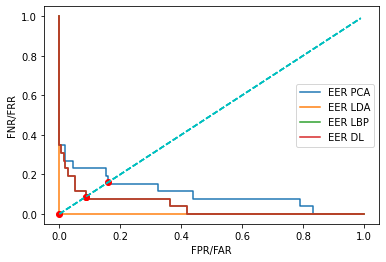

In [73]:
def eer(mask, scores):
    '''Returns x and y dimension of the Equal Error Rate'''
    fpr, tpr, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    frr = 1 - tpr
    line1 = LineString(np.vstack((fpr, frr)).T)
    line2 = LineString([(0,0), (1,1)]) #y=x line
    eer_val = line1.intersection(line2) #find where the two cross each other
    return eer_val.x, eer_val.y

eer_x_pca, eer_y_pca = eer(genuine_id_pca, scores_pca)
eer_x_lda, eer_y_lda = eer(genuine_id_lda, scores_lda)
eer_x_lbp, eer_y_lbp = eer(genuine_id_lbp, scores_lbp)
eer_x_dl, eer_y_dl = eer(genuine_id_dl, scores_dl)

print(f'Equal Error Rate PCA = {eer_x_pca}')
print(f'Equal Error Rate LDA = {eer_x_lda}')
print(f'Equal Error Rate LBP = {eer_x_lbp}')
print(f'Equal Error Rate DL = {eer_x_dl}')


def plot_FAR_FRR_EER(mask, scores, name):
    '''Plots the FAR-FRR Curve with the EER'''
    eerx, eery = eer(mask, scores)
    fpr, tpr, thresholds = metrics.roc_curve(mask, scores, pos_label=1)
    frr = 1 - tpr
    
    plt.plot(fpr, frr, label='EER '+ name )
    plt.xlabel("FPR/FAR")
    plt.ylabel("FNR/FRR")
    plt.plot(eerx, eery,'ro')
    
    x = np.arange(0,1,0.01)
    y = x
    plt.plot(x,y,'c--')
    plt.legend()
    #plt.annotate("EER", (eerx + 0.1, eery + 0.1))

plot_FAR_FRR_EER(genuine_id_pca, scores_pca, 'PCA')
plot_FAR_FRR_EER(genuine_id_lda, scores_lda, 'LDA')
plot_FAR_FRR_EER(genuine_id_lbp, scores_lbp, 'LBP')
plot_FAR_FRR_EER(genuine_id_dl, scores_dl, 'DL')

<div class="alert alert-block alert-success">
<b>Q5: </b> Calculate classification scores
</div>

AUPR PCA: 0.7390212870407671
AUPR DL: 0.8028867837944156
AUPR LDA: 1.0
AUPR LBP: 0.8028867837944156


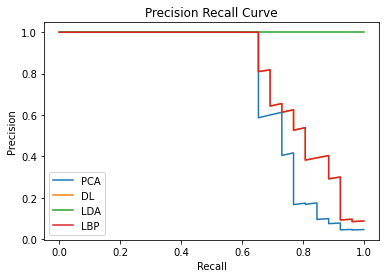

In [74]:
def PRCurve(mask, scores, name):
    '''Plots the Precision Recall Curve'''
    precision, recall, thresholds = precision_recall_curve(mask, scores)
    plt.plot(recall, precision, label=name)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    return precision, recall

def aupr(mask, scores):
    '''Returns the Area Under the Precision Recall Curve'''
    precision, recall, thresholds = precision_recall_curve(mask, scores)
    aupr_val = metrics.auc(recall, precision)
    return aupr_val

PRCurve(genuine_id_pca, scores_pca, 'PCA')
aupr_pca = aupr(genuine_id_pca, scores_pca)

PRCurve(genuine_id_dl, scores_dl, 'DL')
aupr_dl = aupr(genuine_id_dl, scores_dl)

PRCurve(genuine_id_lda, scores_lda, 'LDA')
aupr_lda = aupr(genuine_id_lda, scores_lda)

PRCurve(genuine_id_lbp, scores_lbp, 'LBP')
aupr_lbp = aupr(genuine_id_lbp, scores_lbp)


print('AUPR PCA: {}'.format(aupr_pca))
print('AUPR DL: {}'.format(aupr_dl))
print('AUPR LDA: {}'.format(aupr_lda))
print('AUPR LBP: {}'.format(aupr_lbp))

In [75]:
#Average Precision
average_precision_pca = average_precision_score(genuine_id_pca, scores_pca)
average_precision_lbp = average_precision_score(genuine_id_lbp, scores_lbp)
average_precision_lda = average_precision_score(genuine_id_lda, scores_lda)
average_precision_dl = average_precision_score(genuine_id_dl, scores_dl)

print('Average Precision PCA: {}'.format(average_precision_pca))
print('Average Precision LBP: {}'.format(average_precision_lbp))
print('Average Precision LDA: {}'.format(average_precision_lda))
print('Average Precision DL: {}'.format(average_precision_dl))

Average Precision PCA: 0.7402313624769943
Average Precision LBP: 0.8044698249224654
Average Precision LDA: 1.0
Average Precision DL: 0.8044698249224654


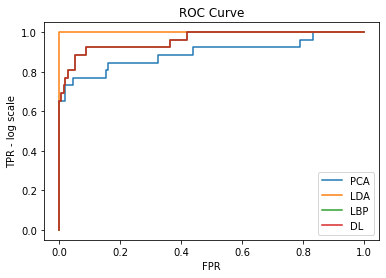

In [76]:
def plot_ROC(mask, scores, name, scale):
    '''Plots ROC curve'''
    fpr, tpr, _ = metrics.roc_curve(mask, scores, pos_label=1)

    plt.plot(fpr, tpr, label = name)
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR - log scale")
    plt.title('ROC Curve')
    
    if scale=='log':
        plt.xscale('log')
        plt.yscale('log')
        

plot_ROC(genuine_id_pca, scores_pca, 'PCA', scale='normal')
plot_ROC(genuine_id_lda, scores_lda, 'LDA', scale='normal')
plot_ROC(genuine_id_lbp, scores_lbp, 'LBP', scale='normal')
plot_ROC(genuine_id_dl, scores_dl, 'DL', scale='normal')


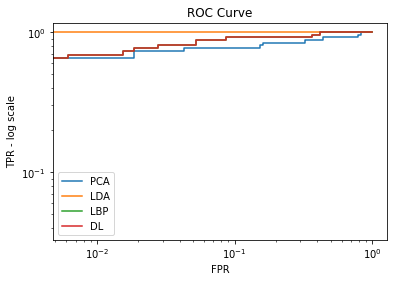

In [77]:
#ROC curve in log scale
plot_ROC(genuine_id_pca, scores_pca, 'PCA', scale='log')
plot_ROC(genuine_id_lda, scores_lda, 'LDA', scale='log')
plot_ROC(genuine_id_lbp, scores_lbp, 'LBP', scale='log')
plot_ROC(genuine_id_dl, scores_dl, 'DL', scale='log')

### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q6: </b> Generate a Cumulative Matching Curve
</div>

In [78]:
def normalize_matrix(similarity_matrix):
    '''Normalizes a matrix to [0,1] - Used for the similarity matrices'''
    sim_matr = similarity_matrix.values
    sim_matr = (sim_matr - sim_matr.min())/(sim_matr.max()-sim_matr.min())
    return sim_matr

def CMC(similarity_matrix):
    '''Constructs what is needed for the Cumulative Matching Characteristic Curve'''
    rows, columns = similarity_matrix.shape
    ranks = np.arange(1,rows+1)
    hits_per_rank = []
    for r in ranks:
        hits = 0
        for j in range(rows):
            a = similarity_matrix[j,:]
            indices = (-a).argsort()[:r]
            if j in indices: hits += 1
        hits = (hits/rows) * 100
        hits_per_rank.append(hits)
    return ranks, hits_per_rank

def rank1(similarity_matrix, name):
    '''Prints Rank 1 identification rate'''
    ranks, hits = CMC(normalize_matrix(similarity_matrix))
    print(name + ': Rank 1 identification rate: '+ str(hits[0]))

def plotCMC(ranks, hits_per_rank, name):
    '''Plots the CMC curve'''
    plt.plot(ranks, hits_per_rank, label=name)
    plt.legend()
    plt.xlabel('Rank '+ str(len(ranks)))
    plt.ylabel('Rank '+ str(len(ranks))+ ' identification rate (%)')
    plt.title('CMC')

PCA: Rank 1 identification rate: 84.61538461538461
LBP: Rank 1 identification rate: 92.3076923076923
LDA: Rank 1 identification rate: 100.0
DL: Rank 1 identification rate: 92.3076923076923


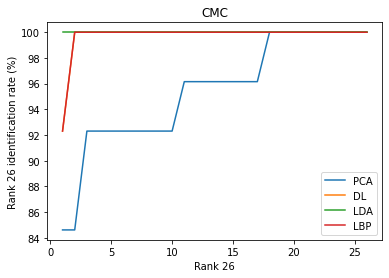

In [79]:
ranks_pca, hits_pca = CMC(normalize_matrix(sim_mat_pca))
plotCMC(ranks_pca, hits_pca, 'PCA')

ranks_dl, hits_dl = CMC(normalize_matrix(sim_mat_dl))
plotCMC(ranks_dl, hits_dl, 'DL')

ranks_lda, hits_lda = CMC(normalize_matrix(sim_mat_lda))
plotCMC(ranks_lda, hits_lda, 'LDA')

ranks_lbp, hits_lbp = CMC(normalize_matrix(sim_mat_lbp))
plotCMC(ranks_lbp, hits_lbp, 'LBP')

#Print rank 1 rates
rank1(sim_mat_pca, 'PCA')
rank1(sim_mat_lbp, 'LBP')
rank1(sim_mat_lda, 'LDA')
rank1(sim_mat_dl, 'DL')


### 3. Validation in multi-classification setting
<div class="alert alert-block alert-success">
<b>Q7: </b> Validate the advanced classification scenario
You can choose an appropriate metric.
</div>

In [80]:
#Cross validation
from sklearn.model_selection import cross_val_score

def get_cross_validation(classifier, X, y, name):
    '''Gets mean accuracy from cross validation'''
    cv_scores = cross_val_score(classifier, X, y, cv=5) 
    print(cv_scores)
    print(name+' cv_scores mean:{}'.format(np.mean(cv_scores)))

In [81]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean') #Re-initialize the knn classifier

knn.fit(X_train_class_pca, y_train_class_pca)
acc_knn_pca = accuracy_score(y_test_class_pca, knn.predict(X_test_class_pca))
print(f'KNN accuracy - PCA = {acc_knn_pca}')
get_cross_validation(knn, X_test_class_pca, y_test_class_pca, 'PCA')
print('F1 score: '+str(f1_score(y_test_class_pca, knn.predict(X_test_class_pca), average='macro'))) 
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
print()

knn.fit(X_train_class_lbp, y_train_class_lbp)
acc_knn_lbp = accuracy_score(y_test_class_lbp, knn.predict(X_test_class_lbp))
print(f'KNN accuracy - LBP = {acc_knn_lbp}')
get_cross_validation(knn, X_test_class_lbp, y_test_class_lbp, 'LBP')

print('F1 score: '+str(f1_score(y_test_class_lbp, knn.predict(X_test_class_lbp), average='macro')))
print()

knn.fit(X_train_class_lda, y_train_class_lda)
acc_knn_lda = accuracy_score(y_test_class_lda, knn.predict(X_test_class_lda))
print(f'KNN accuracy - LDA = {acc_knn_lda}')
get_cross_validation(knn, X_test_class_lda, y_test_class_lda, 'LDA')

print('F1 score: '+str(f1_score(y_test_class_lda, knn.predict(X_test_class_lda), average='macro')))
print()

knn.fit(X_train_class_dl, y_train_class_dl)
acc_knn_dl = accuracy_score(y_test_class_dl, knn.predict(X_test_class_dl))
print(f'KNN accuracy - DL = {acc_knn_dl}')
get_cross_validation(knn, X_test_class_dl, y_test_class_dl, 'DL')

print('F1 score: '+str(f1_score(y_test_class_dl, knn.predict(X_test_class_dl), average='macro')))
print()

KNN accuracy - PCA = 0.9090909090909091
[0.81818182 0.90909091 0.63636364 0.77272727 0.68181818]
PCA cv_scores mean:0.7636363636363637
F1 score: 0.8451437451437452

KNN accuracy - LBP = 0.8454545454545455
[0.68181818 0.68181818 0.59090909 0.63636364 0.72727273]
LBP cv_scores mean:0.6636363636363637
F1 score: 0.7437506937506936

KNN accuracy - LDA = 0.990909090909091
[0.95454545 1.         0.90909091 0.95454545 0.90909091]
LDA cv_scores mean:0.9454545454545455
F1 score: 0.9880341880341881

KNN accuracy - DL = 0.9818181818181818
[0.95454545 1.         0.90909091 0.95454545 0.95454545]
DL cv_scores mean:0.9545454545454547
F1 score: 0.9504273504273505



C:\Users\evaba\anaconda3\envs\CV\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\evaba\anaconda3\envs\CV\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\evaba\anaconda3\envs\CV\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\evaba\anaconda3\envs\CV\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


## VII. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

<em>Note: in case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. </em>

### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance.

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

e.g. performing task 6 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters, activation functions does not count.


<div class="alert alert-block alert-success">
<b>Task 3 - </b>  Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
</div>

In [82]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

#Parameters from grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1) #Initialize SVM classifier

#PCA
grid.fit(X_train_class_pca, y_train_class_pca)
predictions_pca = grid.predict(X_test_class_pca)
print(f'SVM accuracy - PCA = {accuracy_score(y_test_class_pca, predictions_pca)}')
print('F1 score: '+str(f1_score(y_test_class_pca, predictions_pca, average='macro'))) 
#print(classification_report(y_test_class_lbp, predictions_lbp)) #Uncomment these lines to get the 
#                                                                #classification report and the best parameters from the grid search
#print(grid.best_estimator_)
print()

#LBP
grid.fit(X_train_class_lbp, y_train_class_lbp)
predictions_lbp = grid.predict(X_test_class_lbp)
print(f'SVM accuracy - LBP = {accuracy_score(y_test_class_lbp, predictions_lbp)}')
print('F1 score: '+str(f1_score(y_test_class_lbp, predictions_lbp, average='macro'))) 
print()

#LDA

grid.fit(X_train_class_lda, y_train_class_lda)
predictions_lda = grid.predict(X_test_class_lda)
print(f'SVM accuracy - LDA = {accuracy_score(y_test_class_lda, predictions_lda)}')
print('F1 score: '+str(f1_score(y_test_class_lbp, predictions_lda, average='macro'))) 
print()

#DL
grid.fit(X_train_class_dl, y_train_class_dl)
predictions_dl = grid.predict(X_test_class_dl)
print(f'SVM accuracy - DL = {accuracy_score(y_test_class_dl, predictions_dl)}')
print('F1 score: '+str(f1_score(y_test_class_dl, predictions_dl, average='macro'))) 
print()


Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVM accuracy - PCA = 0.9272727272727272
F1 score: 0.829646848877618

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVM accuracy - LBP = 0.8727272727272727
F1 score: 0.7775465987004448

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVM accuracy - LDA = 0.990909090909091
F1 score: 0.9922299922299923

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVM accuracy - DL = 0.990909090909091
F1 score: 0.9572649572649573




<div class="alert alert-block alert-success">
<b>Task 6 - </b> Implement a different deep learning model* (2pt.)
</div>

### Facenet - Implementation

In [84]:
#Import facenet weights from local computer
from keras.models import load_model
facenet_model = load_model('C:/Users/evaba/Desktop/3_face_recognition/facenet_keras.h5')

In [ ]:
# #--------------------------------------
# #Uncomment this cell to plot the model as a png file
# #--------------------------------------
#plot_model(facenet_model, to_file='model_facenet.png', show_shapes = True, show_layer_names = True)

In [85]:
#Method to get embeddings with Facenet

def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

In [86]:
#Reload the Caltech dataset in RGB

def read_img_rgb(imagePath):
    gray = cv2.imread(str(imagePath), cv2.IMREAD_COLOR)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    
    return gray, imagePath.parent.name

# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs_new = [read_img_rgb(imagePath) for imagePath in imagePaths]
data_new = pd.DataFrame(imgs_new, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully (5 images were removed from the original set)
assert len(data_new['images']) == len(data['target']) == 445

In [87]:
feat_data_new, images_new, labels_new = [], [], []


for img, label in zip(data_new['images'], data_new['target']):
    faces_new = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces_new:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, (160, 160))
        face_flatten = face.flatten()
        
#         images_new.append(np.expand_dims(face, axis=-1)), feat_data_new.append(face_flatten), labels_new.append(label)
        images_new.append(face), feat_data_new.append(face_flatten), labels_new.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets_new = label_encoder.fit_transform(labels_new)

faces_new = Bunch(data       = np.array(feat_data_new), 
              images     = np.array(images_new), 
              labels     = np.array(labels_new),
              target     = np.array(targets_new))

In [88]:
facenet_images = faces_new.images

embeddings_facenet = []
for f in facenet_images:
    emb = get_embedding(facenet_model, f)
    embeddings_facenet.append(emb)
    
embeddings_facenet_np = np.array(embeddings_facenet)

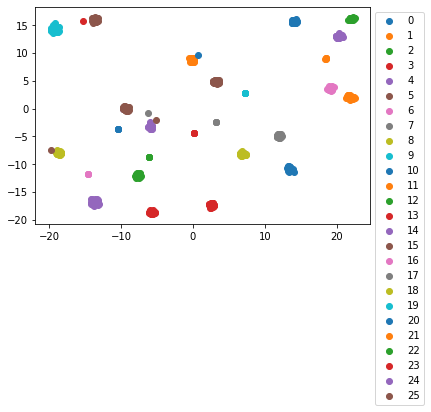

In [89]:
embeddings_facenet_np.shape
plot_tsne(embeddings_facenet_np)

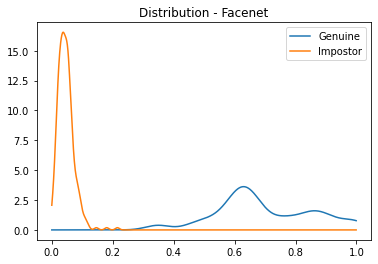

In [90]:
#Construct similarity matrix
dist_metric_facenet = euclidean
sim_mat_facenet = construct_sim_matrix(embeddings_facenet_np, targets, dist_metric_facenet)
genuine_id_facenet, scores_facenet = sim2scores(sim_mat_facenet)

#Split between impostor ang genuine and plot distributions
imp_distr_facenet, gen_distr_facenet = split_genuine_impostor(genuine_id_facenet, scores_facenet)
plotDistributions(gen_distr_facenet, imp_distr_facenet, 'Facenet')

### Facenet - Evaluation

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1.        , 0.96153846, 0.92307692, 0.88461538, 0.84615385,
        0.80769231, 0.76923077, 0.73076923, 0.69230769, 0.65384615,
        0.61538462, 0.57692308, 0.53846154, 0.5       , 0.46153846,
        0.42307692, 0.38461538, 0.34615385, 0.30769231, 0.26923077,
        0.23076923, 0.19230769, 0.15384615, 0.11538462, 0.07692308,
        0.03846154, 0.        ]))

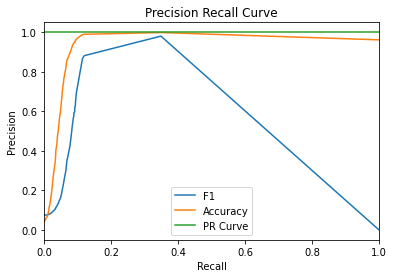

In [91]:
plot_F1(genuine_id_facenet, scores_facenet, 'F1')
plot_Accuracy(genuine_id_facenet, scores_facenet, 'Accuracy')
PRCurve(genuine_id_facenet, scores_facenet, 'PR Curve')

In [92]:
aupr_facenet = aupr(genuine_id_facenet, scores_facenet)
print('AUPR Facenet: {}'.format(aupr_facenet))

AUPR Facenet: 1.0


Facenet: Rank 1 identification rate: 100.0


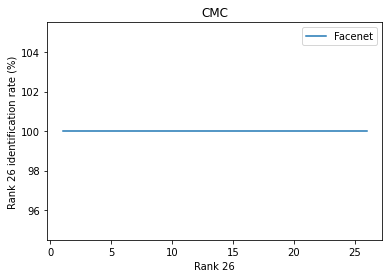

In [93]:
ranks_facenet, hits_facenet = CMC(normalize_matrix(sim_mat_facenet))
plotCMC(ranks_facenet, hits_facenet, 'Facenet')

#Print rank 1 rates
rank1(sim_mat_facenet, 'Facenet')


<div class="alert alert-block alert-success">
<b>Task 1 - </b> Evaluate your system on the other two datasets. (ATT, LFW) (1pt.)
</div>

## LFW dataset

In [94]:
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples_lfw, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features_lfw = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


print("Total dataset size:")
print("n_samples: %d" % n_samples_lfw)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 2209
n_classes: 7


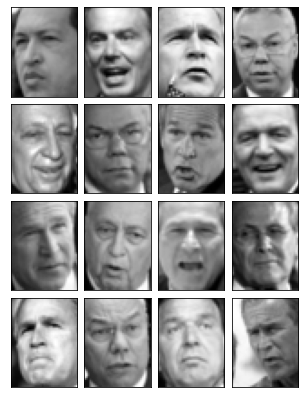

In [95]:
#plt.imshow(lfw_people.images[1], cmap='gray')

fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, lfw_people['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [96]:
#PCA
desc = PCA(n_components=25, svd_solver='randomized', whiten=True).fit(lfw_people.data)
embedded_pca_lfw = desc.transform(lfw_people.data)

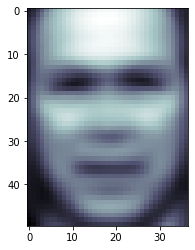

In [97]:
#Mean face with PCA
plt.imshow(desc.mean_.reshape(lfw_people.images[0].shape),
           cmap=plt.cm.bone)

In [98]:
#LDA
desc = LinearDiscriminantAnalysis(n_components=6).fit(lfw_people.data, lfw_people.target)
embedded_lda_lfw = desc.fit_transform(lfw_people.data, lfw_people.target)

In [99]:
#LBP
desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_lbp_lfw = desc.describe_list(lfw_people.images)

In [100]:
#DL
X_lfw = np.stack((lfw_people.images,)*3, axis=-1)
X_lfw_resized = []

for i in X_lfw:
    resized = cv2.resize(i, [30,30], interpolation = cv2.INTER_AREA)
    X_lfw_resized = X_lfw_resized + [resized]
            
    # transform images list to numpy array
    dataset = np.stack(X_lfw_resized, axis=0)
    dataset = dataset.astype('int')

imshape_lfw = dataset.shape

encoder, model = siamese.create_siamese_model([30,30,3])
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(dataset, lfw_people.target))
rms = Adam()
model.compile(loss=siamese.contrastive_loss, optimizer=rms, metrics = [siamese.accuracy])
epochs = 20
model.fit([x_train[:, 0], x_train[:, 1]], y_train, validation_split=0.2, batch_size=32, verbose=2, epochs=epochs)

Train on 1200 samples, validate on 300 samples
Epoch 1/20
1200/1200 - 1s - loss: 0.1382 - accuracy: 0.5329 - val_loss: 0.1203 - val_accuracy: 0.5813
Epoch 2/20
1200/1200 - 1s - loss: 0.1150 - accuracy: 0.6160 - val_loss: 0.1228 - val_accuracy: 0.5552
Epoch 3/20
1200/1200 - 1s - loss: 0.1026 - accuracy: 0.6727 - val_loss: 0.1077 - val_accuracy: 0.6573
Epoch 4/20
1200/1200 - 1s - loss: 0.0911 - accuracy: 0.7673 - val_loss: 0.1025 - val_accuracy: 0.6719
Epoch 5/20
1200/1200 - 1s - loss: 0.0825 - accuracy: 0.8010 - val_loss: 0.0995 - val_accuracy: 0.6490
Epoch 6/20
1200/1200 - 1s - loss: 0.0750 - accuracy: 0.8405 - val_loss: 0.0972 - val_accuracy: 0.6865
Epoch 7/20
1200/1200 - 1s - loss: 0.0663 - accuracy: 0.8635 - val_loss: 0.0931 - val_accuracy: 0.7531
Epoch 8/20
1200/1200 - 1s - loss: 0.0623 - accuracy: 0.8873 - val_loss: 0.0842 - val_accuracy: 0.7635
Epoch 9/20
1200/1200 - 1s - loss: 0.0541 - accuracy: 0.9046 - val_loss: 0.0831 - val_accuracy: 0.7698
Epoch 10/20
1200/1200 - 1s - loss: 

In [101]:
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_dl_lfw = encoder(dataset.astype(float)).numpy()

Accuracy on the test set: 0.846

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Olivetti faces

In [102]:
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState

rng = RandomState(0)
faces_olivetti = fetch_olivetti_faces(return_X_y=False, shuffle=True, random_state=rng)

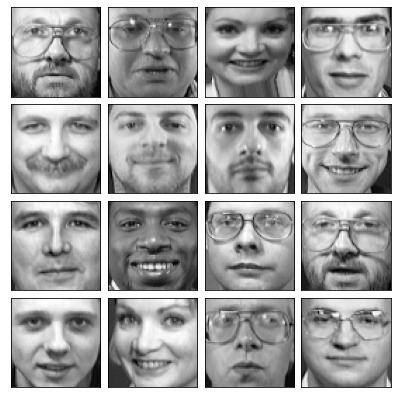

In [103]:
fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces_olivetti.images[0:50]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

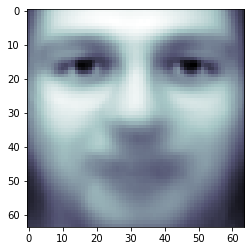

In [104]:
#PCA
desc = PCA(n_components=35, svd_solver='randomized', whiten=True).fit(faces_olivetti.data)
embedded_pca_att = desc.transform(faces_olivetti.data)

#Plot mean with PCA
plt.imshow(desc.mean_.reshape(faces_olivetti.images[0].shape), cmap=plt.cm.bone)

#LDA
desc = LinearDiscriminantAnalysis(n_components=35).fit(faces_olivetti.data, faces_olivetti.target)
embedded_lda_att = desc.fit_transform(faces_olivetti.data, faces_olivetti.target)

#LBP
desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_lbp_att = desc.describe_list(faces_olivetti.images)

In [105]:
#DL
X_att = np.stack((faces_olivetti.images,)*3, axis=-1)

encoder, model = siamese.create_siamese_model([64,64,3])
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(X_att, faces_olivetti.target))
rms = Adam()
model.compile(loss=siamese.contrastive_loss, optimizer=rms, metrics = [siamese.accuracy])
epochs = 10
model.fit([x_train[:, 0], x_train[:, 1]], y_train, validation_split=0.2, batch_size=32, verbose=2, epochs=epochs)
    

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 - 4s - loss: 0.1344 - accuracy: 0.6382 - val_loss: 0.0763 - val_accuracy: 0.7833
Epoch 2/10
1200/1200 - 2s - loss: 0.0642 - accuracy: 0.8141 - val_loss: 0.0566 - val_accuracy: 0.8635
Epoch 3/10
1200/1200 - 2s - loss: 0.0455 - accuracy: 0.8947 - val_loss: 0.0433 - val_accuracy: 0.9187
Epoch 4/10
1200/1200 - 2s - loss: 0.0375 - accuracy: 0.9194 - val_loss: 0.0395 - val_accuracy: 0.9229
Epoch 5/10
1200/1200 - 2s - loss: 0.0326 - accuracy: 0.9416 - val_loss: 0.0353 - val_accuracy: 0.9563
Epoch 6/10
1200/1200 - 2s - loss: 0.0282 - accuracy: 0.9605 - val_loss: 0.0358 - val_accuracy: 0.9448
Epoch 7/10
1200/1200 - 2s - loss: 0.0255 - accuracy: 0.9655 - val_loss: 0.0327 - val_accuracy: 0.9719
Epoch 8/10
1200/1200 - 2s - loss: 0.0236 - accuracy: 0.9712 - val_loss: 0.0296 - val_accuracy: 0.9844
Epoch 9/10
1200/1200 - 2s - loss: 0.0219 - accuracy: 0.9811 - val_loss: 0.0300 - val_accuracy: 0.9781
Epoch 10/10
1200/1200 - 2s - loss: 

In [106]:
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded_dl_att = encoder(X_att.astype(float)).numpy()

Accuracy on the test set: 0.968

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [107]:
#New similarity matrices for the LFW dataset
sim_mat_pca_lfw = construct_sim_matrix(embedded_pca_lfw, lfw_people.target, dist_metric_pca)
sim_mat_lda_lfw = construct_sim_matrix(embedded_lda_lfw, lfw_people.target, dist_metric_lda)
sim_mat_lbp_lfw = construct_sim_matrix(embedded_lbp_lfw, lfw_people.target, dist_metric_lbp)
sim_mat_dl_lfw = construct_sim_matrix(embedded_lbp_lfw, lfw_people.target, dist_func=get_norm)

In [108]:
#New similarity matrices for the AT&T dataset
sim_mat_pca_att = construct_sim_matrix(embedded_pca_att, faces_olivetti.target, dist_metric_pca)
sim_mat_lda_att = construct_sim_matrix(embedded_lda_att, faces_olivetti.target, dist_metric_lda)
sim_mat_lbp_att = construct_sim_matrix(embedded_lbp_att, faces_olivetti.target, dist_metric_lbp)
sim_mat_dl_att = construct_sim_matrix(embedded_lbp_att, faces_olivetti.target, dist_func=get_norm)

In [109]:
def get_evaluation(s1, name1, s2, name2, s3, name3 ,s4, name4):
    genuine_id_a, scores_a = sim2scores(s1)
    genuine_id_b, scores_b = sim2scores(s2)
    genuine_id_c, scores_c = sim2scores(s3)
    genuine_id_d, scores_d = sim2scores(s4)
    
    #F1
    plt.figure()
    plot_F1(genuine_id_a, scores_a, name1)
    plot_F1(genuine_id_b, scores_b, name2)
    plot_F1(genuine_id_c, scores_c, name3)
    plot_F1(genuine_id_d, scores_d, name4)
    
    #Accuracy
    plt.figure()
    plot_Accuracy(genuine_id_a, scores_a, name1)
    plot_Accuracy(genuine_id_b, scores_b, name2)
    plot_Accuracy(genuine_id_c, scores_c, name3)
    plot_Accuracy(genuine_id_d, scores_d, name4)
    
    #CMC
    plt.figure()
    ranks, hits = CMC(normalize_matrix(s1))
    plotCMC(ranks, hits, name1)
    ranks, hits = CMC(normalize_matrix(s2))
    plotCMC(ranks, hits, name2)
    ranks, hits = CMC(normalize_matrix(s3))
    plotCMC(ranks, hits, name3)
    ranks, hits = CMC(normalize_matrix(s4))
    plotCMC(ranks, hits, name4)
    
    plt.figure()
    PRCurve(genuine_id_a, scores_a, name1)
    aupr_pca = aupr(genuine_id_a, scores_a)
    
    PRCurve(genuine_id_b, scores_b, name2)
    aupr_lda = aupr(genuine_id_b, scores_b)
    
    PRCurve(genuine_id_c, scores_c, name3)
    aupr_lbp = aupr(genuine_id_c, scores_c)
    
    PRCurve(genuine_id_d, scores_d, name4)
    aupr_dl = aupr(genuine_id_d, scores_d)


    print('AUPR PCA: {}'.format(aupr_pca))
    print('AUPR DL: {}'.format(aupr_dl))
    print('AUPR LDA: {}'.format(aupr_lda))
    print('AUPR LBP: {}'.format(aupr_lbp))
    

AUPR PCA: 0.9133403361344536
AUPR DL: 0.6804820215306149
AUPR LDA: 0.9999999999999998
AUPR LBP: 0.6804820215306149


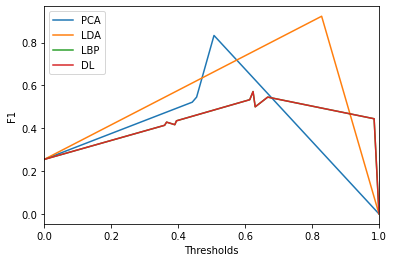

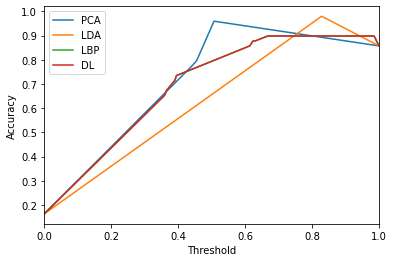

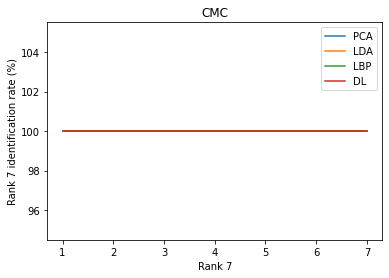

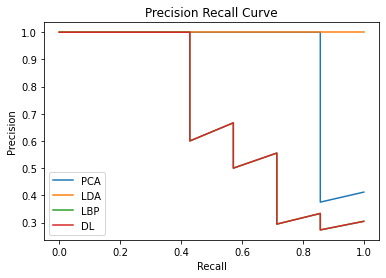

In [114]:
get_evaluation(sim_mat_pca_lfw, 'PCA', sim_mat_lda_lfw, 'LDA', sim_mat_lbp_lfw, 'LBP', sim_mat_dl_lfw, 'DL')

AUPR PCA: 0.8045267416480287
AUPR DL: 0.7124019850573746
AUPR LDA: 1.0
AUPR LBP: 0.7124019850573746


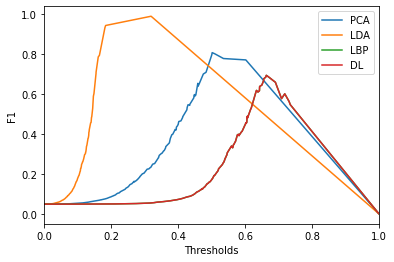

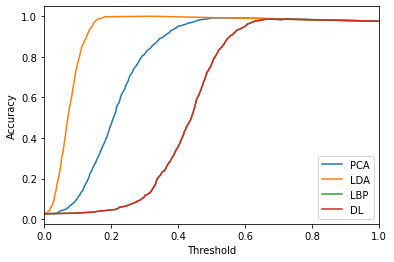

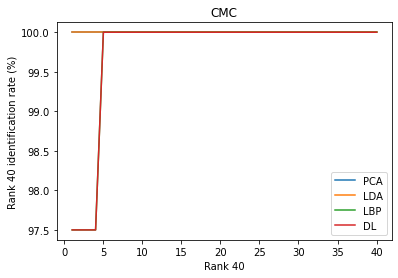

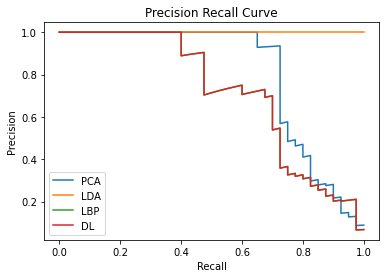

In [111]:
get_evaluation(sim_mat_pca_att, 'PCA', sim_mat_lda_att, 'LDA', sim_mat_lbp_att, 'LBP', sim_mat_dl_att, 'DL')

In [112]:
rank1(sim_mat_pca_lfw, 'PCA')
rank1(sim_mat_lbp_lfw, 'LBP')
rank1(sim_mat_lda_lfw, 'LDA')
rank1(sim_mat_dl_lfw, 'DL')

PCA: Rank 1 identification rate: 100.0
LBP: Rank 1 identification rate: 100.0
LDA: Rank 1 identification rate: 100.0
DL: Rank 1 identification rate: 100.0


In [113]:
rank1(sim_mat_pca_att, 'PCA')
rank1(sim_mat_lbp_att, 'LBP')
rank1(sim_mat_lda_att, 'LDA')
rank1(sim_mat_dl_att, 'DL')

PCA: Rank 1 identification rate: 100.0
LBP: Rank 1 identification rate: 97.5
LDA: Rank 1 identification rate: 100.0
DL: Rank 1 identification rate: 97.5


In [ ]:
#   _                                     _                                                     
#  | |                                   (_)                                                    
#  | |__   __ ___   _____    __ _   _ __  _  ___ ___   ___ _   _ _ __ ___  _ __ ___   ___ _ __  
#  | '_ \ / _` \ \ / / _ \  / _` | | '_ \| |/ __/ _ \ / __| | | | '_ ` _ \| '_ ` _ \ / _ \ '__| 
#  | | | | (_| |\ V /  __/ | (_| | | | | | | (_|  __/ \__ \ |_| | | | | | | | | | | |  __/ |    
#  |_| |_|\__,_| \_/ \___|  \__,_| |_| |_|_|\___\___| |___/\__,_|_| |_| |_|_| |_| |_|\___|_|    
#                                                                                     